[nltk_data] Downloading package stopwords to /home/mf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NLTK resources downloaded successfully.
Loaded 6153 sentences.


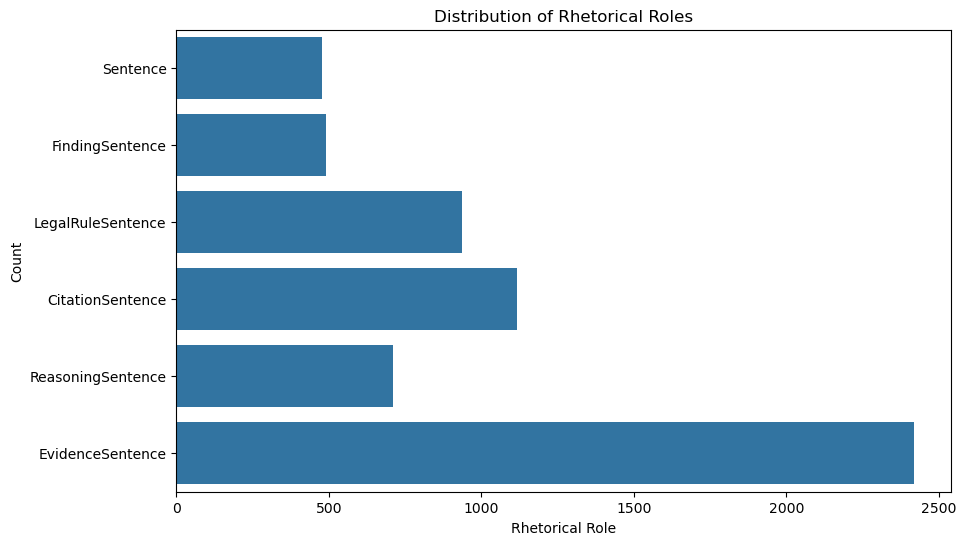

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Model Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Weighted F1 Score: 0.8109

Classification Report:
                   precision    recall  f1-score   support

 CitationSentence       0.99      0.99      0.99       223
 EvidenceSentence       0.80      0.95      0.87       494
  FindingSentence       0.73      0.68      0.70        80
LegalRuleSentence       0.87      0.85      0.86       184
ReasoningSentence       0.78      0.31      0.45       147
         Sentence       0.66      0.68      0.67       103

         accuracy                           0.83      1231
        macro avg       0.80      0.74      0.76      1231
     weighted avg       0.83      0.83      0.81      1231



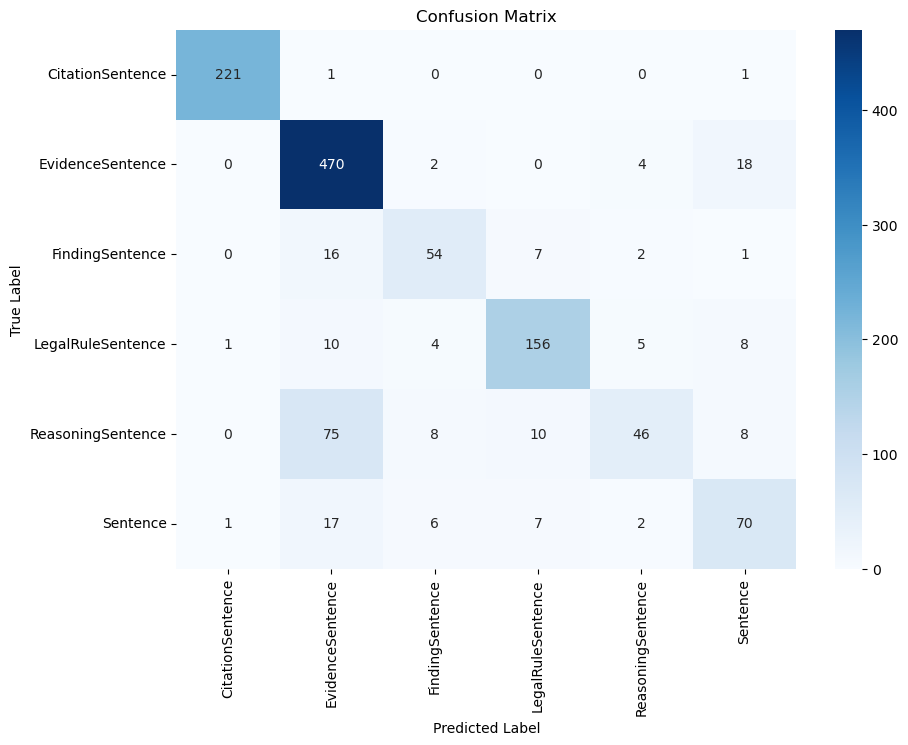

ALL FINISHED
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   4.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split

In [2]:
import os
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

folder_path = '.'

def download_nltk_resources():
    """
    That function downloads essential NLTK resources required for text processing

    return: None
    """
    try:
        print("Downloading NLTK resources...")
        nltk.download('stopwords')
        nltk.download('punkt')
        print("NLTK resources downloaded successfully.")
    except Exception as e:
        print(f"An error occurred while downloading NLTK resources: {e}")

def load_data(folder_path="."):
    """
    That function loads and preprocesses text data from JSON files in a given folder.
    
    param: folder_path (str): path to the folder containing JSON files with text data.
    
    return: sentences (list of str): list of preprocessed sentences extracted from JSON files.
    return: labels (list of str): list of corresponding labels for each sentence.
    """
    sentences = []
    labels = []
    stop_words = set(stopwords.words('english'))

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as f:
                data = json.load(f)
                for sentence in data['sentences']:
                    text = sentence['text']
                    words = word_tokenize(text.lower())
                    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
                    filtered_text = ' '.join(filtered_words)
                    sentences.append(filtered_text)
                    labels.append(sentence['rhetRole'][0])
    return sentences, labels

def perform_eda(labels):
    """
    That function performs exploratory data analysis by visualizing the distribution of labels.
    
    param: labels (list of str): List of labels corresponding to the sentences in the dataset.
    
    return: None
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(labels)
    plt.title("Distribution of Rhetorical Roles")
    plt.xlabel("Rhetorical Role")
    plt.ylabel("Count")
    plt.show()

def vectorize_text(sentences):
    """
    That function converts a list of sentences into a TF-IDF matrix.
    
    param: sentences (list of str): List of preprocessed sentences to be vectorized.
    
    return: X (scipy.sparse.csr.csr_matrix): Sparse matrix of TF-IDF features.
    return: vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer instance.
    """
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(sentences)
    return X, vectorizer

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """
    That function trains a RandomForestClassifier and evaluates its performance on the test set.

    param: X_train (scipy.sparse.csr.csr_matrix): TF-IDF features for the training set.
    param: X_test (scipy.sparse.csr.csr_matrix): TF-IDF features for the test set.
    param: y_train (numpy.ndarray): Labels for the training set.
    param: y_test (numpy.ndarray): Labels for the test set.
    
    return: best_model (RandomForestClassifier): the trained model with the best hyperparameters.
    """
    model = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Best Model Parameters:", grid_search.best_params_)
    print(f"Weighted F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return best_model

if __name__ == '__main__':
    try:
        download_nltk_resources()

        sentences, labels = load_data(folder_path)
        print(f"Loaded {len(sentences)} sentences.")

        perform_eda(labels)

        X, vectorizer = vectorize_text(sentences)
        y = np.array(labels)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model = train_and_evaluate(X_train, X_test, y_train, y_test)

        joblib.dump(best_model, 'rhetorical_role_classifier.pkl')
        joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

    except Exception as e:
        print(f"An error occurred: {e}")

    print("ALL FINISHED")

